# Basics

Importing the datasets

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c covid-segmentation
!unzip \*.zip && rm *.zip

  0% 0.00/563k [00:00<?, ?B/s]
100% 563k/563k [00:00<00:00, 38.7MB/s]
  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 93.5MB/s]
 96% 145M/150M [00:02<00:00, 44.6MB/s]
100% 150M/150M [00:02<00:00, 71.2MB/s]
 43% 6.00M/13.9M [00:00<00:00, 60.7MB/s]
100% 13.9M/13.9M [00:00<00:00, 88.9MB/s]
 97% 306M/316M [00:02<00:00, 119MB/s]
100% 316M/316M [00:02<00:00, 122MB/s]
Archive:  test_images_medseg.npy.zip
  inflating: test_images_medseg.npy  

Archive:  images_radiopedia.npy.zip
  inflating: images_radiopedia.npy   

Archive:  masks_radiopedia.npy.zip
  inflating: masks_radiopedia.npy    

Archive:  masks_medseg.npy.zip
  inflating: masks_medseg.npy        

Archive:  images_medseg.npy.zip
  inflating: images_medseg.npy       

5 archives were successfully processed.


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models
!git clone https://github.com/SlinkoIgor/ImageDataAugmentor.git

import segmentation_models as sm
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-aeqv4okl
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-aeqv4okl
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.7 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=d20b1de7c9e5fb869b779b5512072490dd76999c12b85b69e872d5417514f6cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-uve8c_7z/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 310, done.
remote: Total 310 (delta 0), reused 0 (delta 0), pack-reused 310
Receiving objects: 100% (310/310), 131.62 KiB | 1.75 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Segmentation Models: using `keras` framework.


In [ ]:
prefix = '/content'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

Function for viewing images and their corresponding masks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

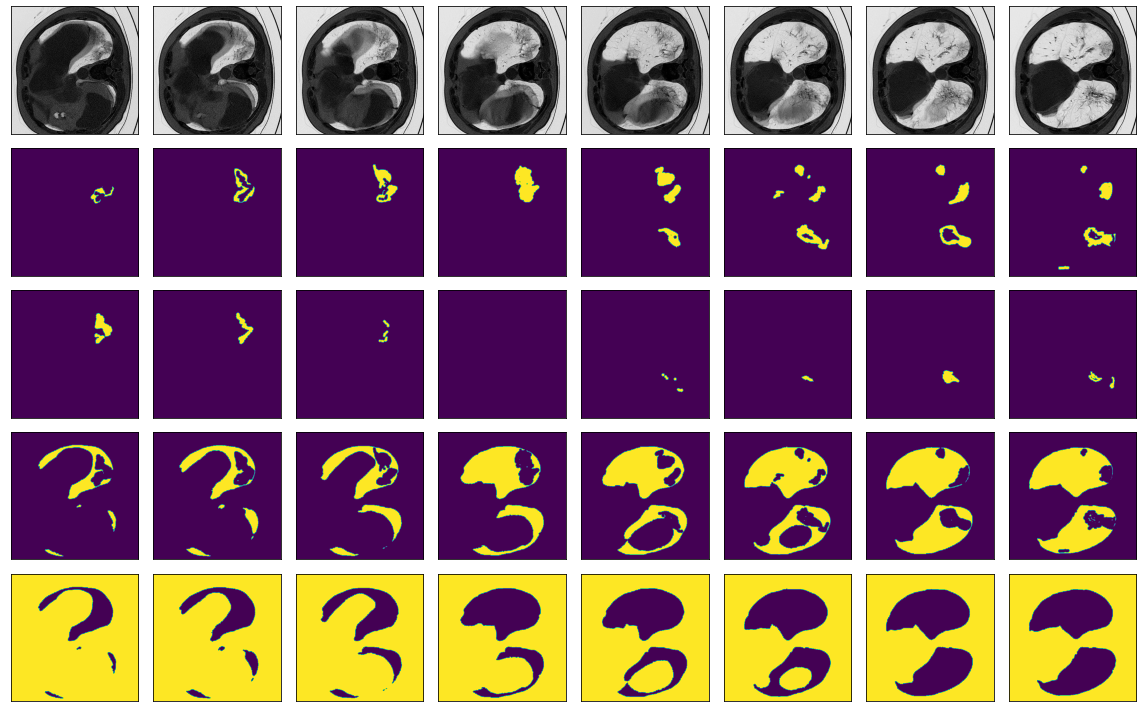

In [ ]:
visualize(images_radiopedia[12:], masks_radiopedia[12:])

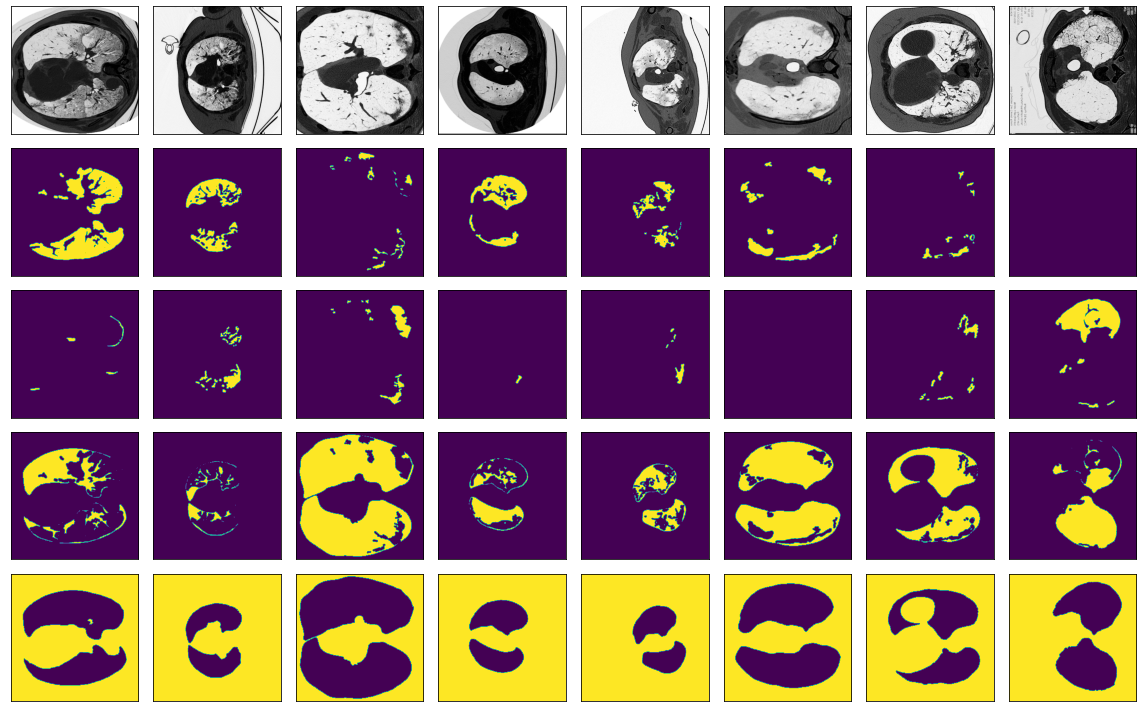

In [ ]:
visualize(images_medseg[8:], masks_medseg[8:])

In [ ]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


In [ ]:
print(images_radiopedia.shape)
print(images_medseg.shape)

(829, 512, 512, 1)
(100, 512, 512, 1)


In [ ]:
test_indexes, val_indexes, train_indexes = list(range(15)), list(range(16,30)), list(range(31, 100))
test_indexes_r, val_indexes_r, train_indexes_r = list(range(125)), list(range(126, 250)), list(range(251, 829))

train_m= images_medseg[train_indexes]
train_r=images_radiopedia[train_indexes_r]
train_m_masks = masks_medseg[train_indexes]
train_r_masks = masks_radiopedia[train_indexes_r]


val_m= images_medseg[val_indexes]
val_r=images_radiopedia[val_indexes_r]

val_m_masks = masks_medseg[val_indexes]
val_r_masks =masks_radiopedia[val_indexes_r]


test_m= images_medseg[test_indexes]
test_r=images_radiopedia[test_indexes_r]
test_m_masks = masks_medseg[test_indexes]
test_r_masks = masks_radiopedia[test_indexes_r]


print(train_m.shape, train_r.shape)
print(val_m.shape, val_r.shape)
print(test_m.shape, test_r.shape)

train_images = np.concatenate((train_m, train_r),axis=0)
val_images = np.concatenate((val_m, val_r),axis=0)
test_images = np.concatenate((test_m, test_r),axis=0)

train_masks = np.concatenate((train_m_masks, train_r_masks),axis=0)
val_masks = np.concatenate((val_m_masks, val_r_masks),axis=0)
test_masks = np.concatenate((test_m_masks, test_r_masks),axis=0)

print(train_images.shape)


(69, 512, 512, 1) (578, 512, 512, 1)
(14, 512, 512, 1) (124, 512, 512, 1)
(15, 512, 512, 1) (125, 512, 512, 1)
(647, 512, 512, 1)


In [ ]:
batch_size = 16

Data generator and augmentations

In [ ]:
import tensorflow

import albumentations
import cv2

SOURCE_SIZE = 512
TARGET_SIZE = 384

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),
    # albumentations.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    # albumentations.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
    # IAAAdditiveGaussianNoise(p=0.2)
])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [ ]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)
test_dataset = Dataset(test_images, test_masks, val_augs)


train_dataloader = Dataloder(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = Dataloder(test_dataset,batch_size=batch_size, shuffle=False)

check shape for errors

In [ ]:
assert train_dataloader[0][0].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 1)
assert train_dataloader[0][1].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 4)

  dataloader

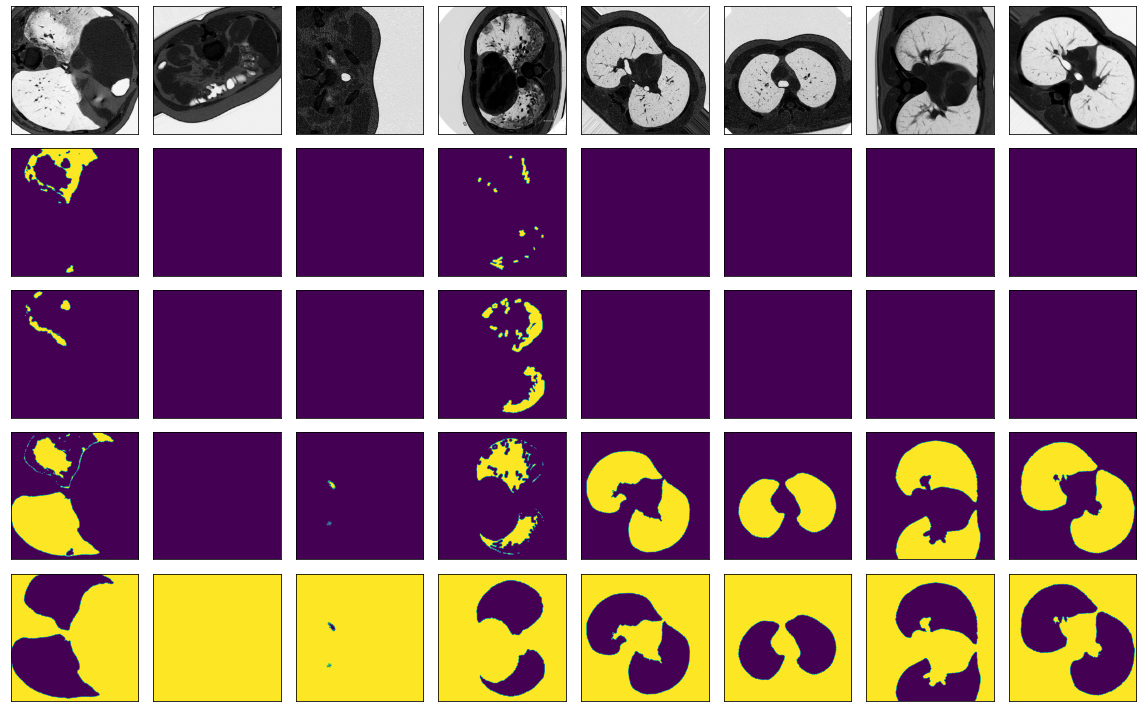

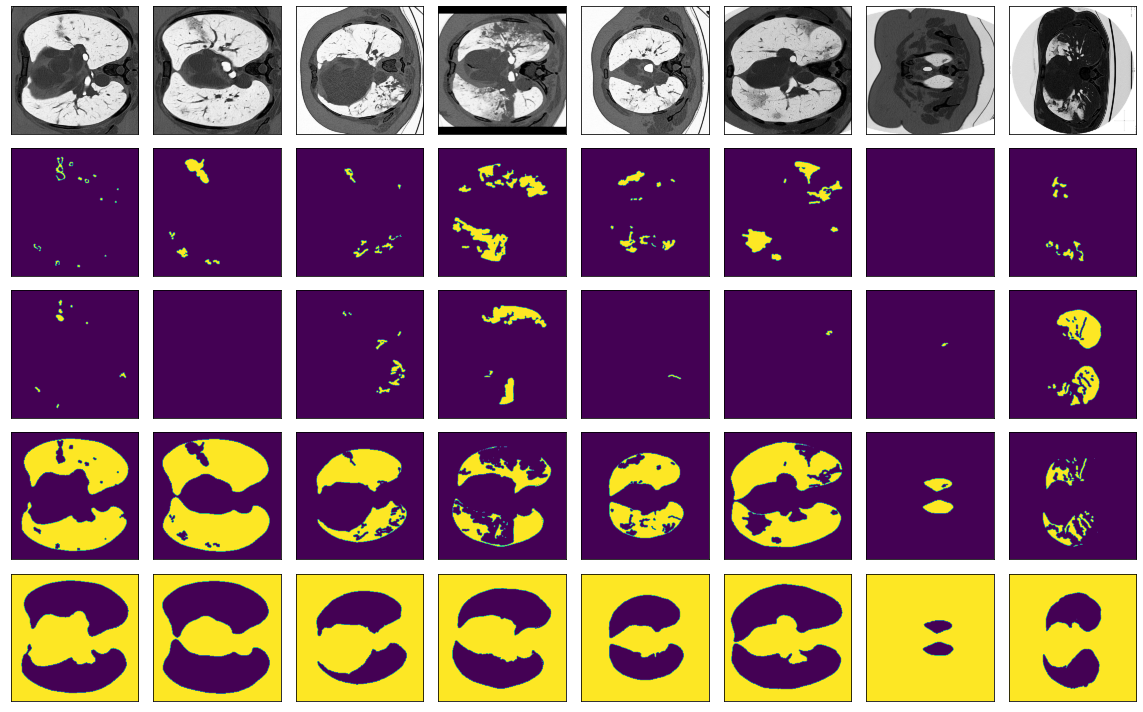

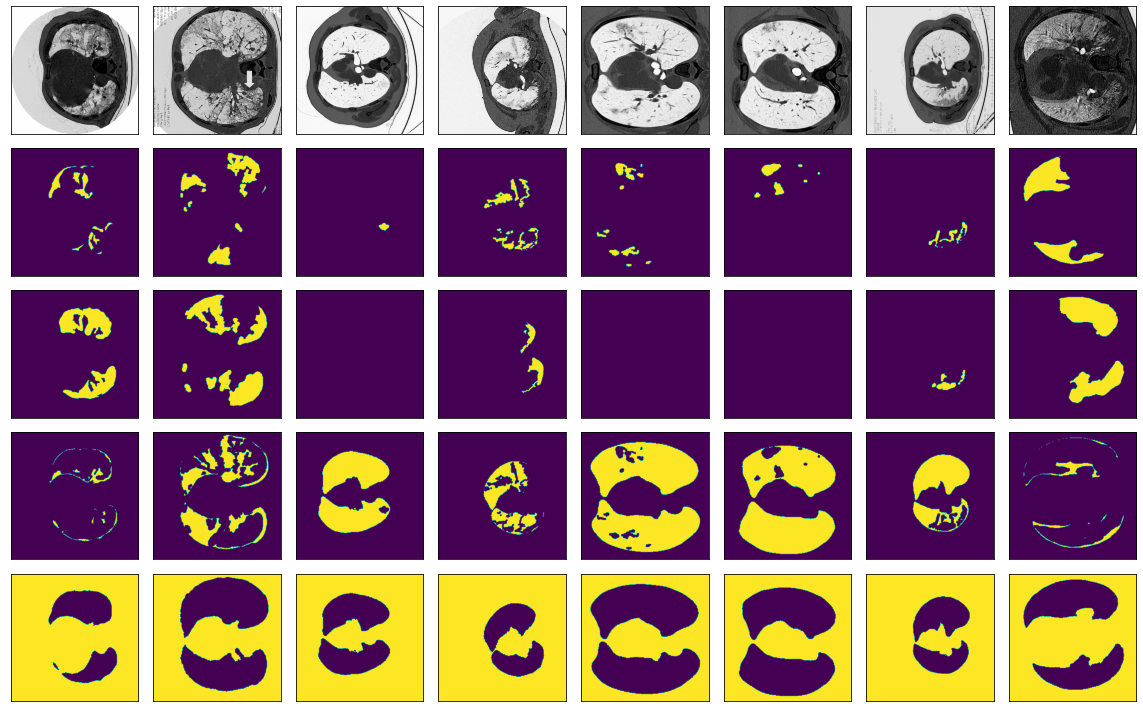

In [ ]:
visualize(*next(iter(train_dataloader)))
visualize(*next(iter(val_dataloader)))
visualize(*next(iter(test_dataloader)))

# PSPNet + EfficientNet B3

Model define

In [ ]:
from segmentation_models import PSPNet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='efficientnetb3',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

44122112/44107200 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 384, 384, 3)       6         
                                                                 
 model (Functional)          (None, 384, 384, 4)       1999170   
                                                                 
Total params: 1,999,176
Trainable params: 1,987,512
Non-trainable params: 11,664
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


ungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/pspnet/Models/K-pspnet-EfficientnetB3.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/pspnet/CSV/K-pspnet-EfficientnetB3.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 107s 2s/step - loss: 0.0831 - iou_score: 0.4197 - f1-score: 0.4493 - val_loss: 0.1129 - val_iou_score: 0.5831 - val_f1-score: 0.6203 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 64s 2s/step - loss: 0.0277 - iou_score: 0.4821 - f1-score: 0.5064 - val_loss: 0.0459 - val_iou_score: 0.6612 - val_f1-score: 0.6839 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 64s 2s/step - loss: 0.0223 - iou_score: 0.5640 - f1-score: 0.6250 - val_loss: 0.0329 - val_iou_score: 0.6709 - val_f1-score: 0.6898 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 66s 2s/step - loss: 0.0188 - iou_score: 0.6256 - f1-score: 0.7021 - val_loss: 0.0231 - val_iou_score: 0.6736 - val_f1-score: 0.6934 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 64s 2s/step - loss: 0.0179 - iou_score: 0.6631 - f1-score: 0.7493 - val_loss: 0.0214 - val_iou_score: 0.6902 - val_f1-score: 0.7219 - lr: 0.0010
Epoch 6/50
40/

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0094836
mean iou_score: 0.80529
mean f1-score: 0.87698


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0080403
mean iou_score: 0.72035
mean f1-score: 0.75535


Plots

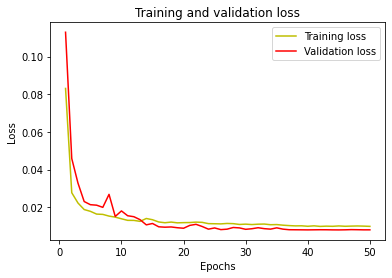

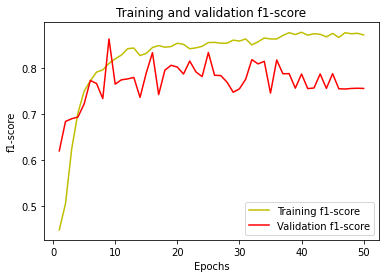

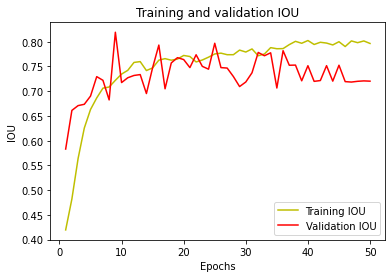

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.019053
mean iou_score: 0.61837
mean f1-score: 0.69168


In [ ]:
print(scores_test)

[0.019052917137742043, 0.6183710694313049, 0.6916773915290833]


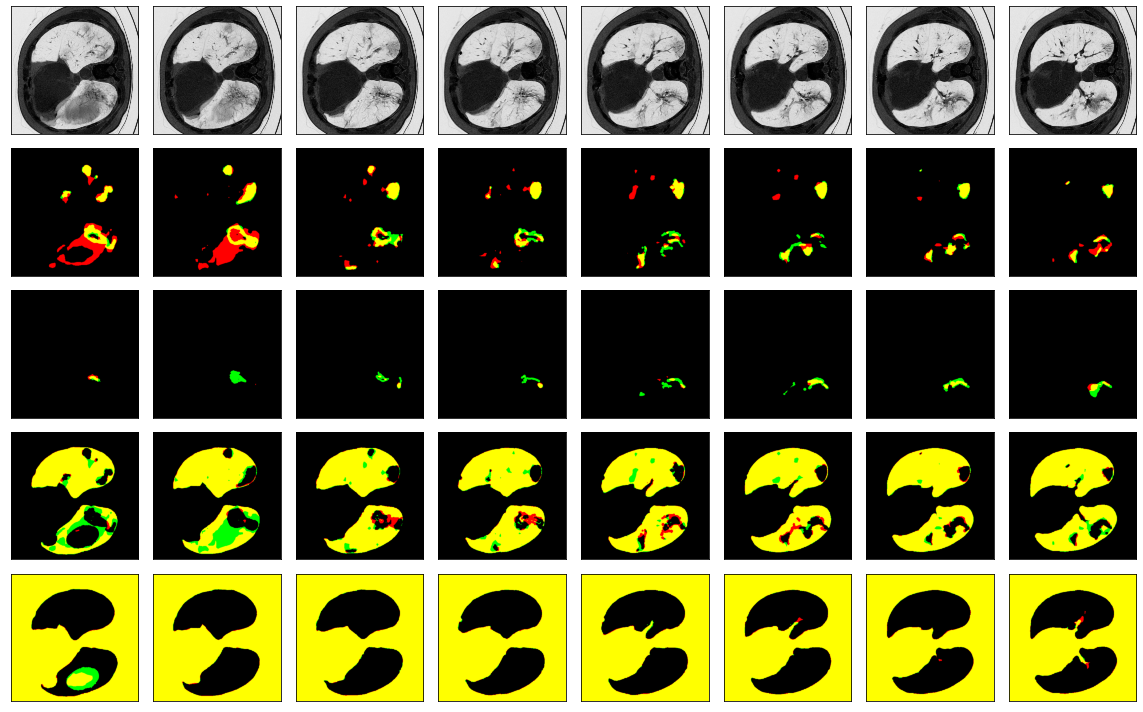

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# PSPNet + VGG19

Model define

In [ ]:
from segmentation_models import PSPNet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='vgg19',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 384, 384, 3)       6         
                                                                 
 model_1 (Functional)        (None, 384, 384, 4)       12973124  
                                                                 
Total params: 12,973,130
Trainable params: 12,968,010
Non-trainable params: 5,120
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/pspnet/Models/K-pspnet-vgg19.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/pspnet/CSV/K-pspnet-vgg19.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 95s 2s/step - loss: 0.1765 - iou_score: 0.2830 - f1-score: 0.3400 - val_loss: 0.4151 - val_iou_score: 0.5659 - val_f1-score: 0.5781 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 70s 2s/step - loss: 0.0716 - iou_score: 0.4242 - f1-score: 0.4626 - val_loss: 0.4120 - val_iou_score: 0.5659 - val_f1-score: 0.5781 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 70s 2s/step - loss: 0.0951 - iou_score: 0.3864 - f1-score: 0.4334 - val_loss: 0.1425 - val_iou_score: 0.6351 - val_f1-score: 0.6726 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 70s 2s/step - loss: 0.0594 - iou_score: 0.4412 - f1-score: 0.4781 - val_loss: 0.3799 - val_iou_score: 0.5659 - val_f1-score: 0.5781 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 70s 2s/step - loss: 0.0475 - iou_score: 0.4651 - f1-score: 0.5024 - val_loss: 0.0441 - val_iou_score: 0.6344 - val_f1-score: 0.6652 - lr: 0.0010
Epoch 6/50
40/4

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.01838
mean iou_score: 0.67671
mean f1-score: 0.76782


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.015846
mean iou_score: 0.60185
mean f1-score: 0.64777


Plots

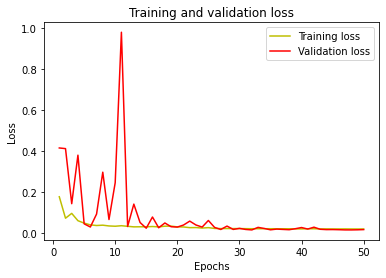

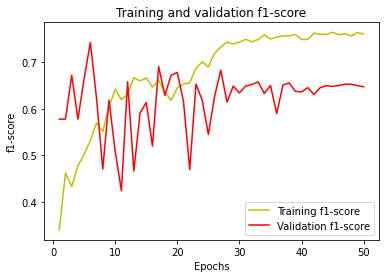

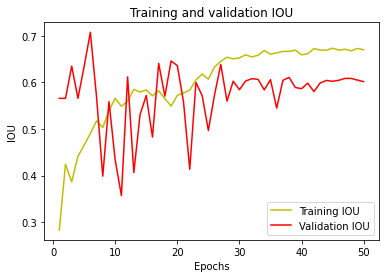

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.03468
mean iou_score: 0.56073
mean f1-score: 0.63603


In [ ]:
print(scores_test)

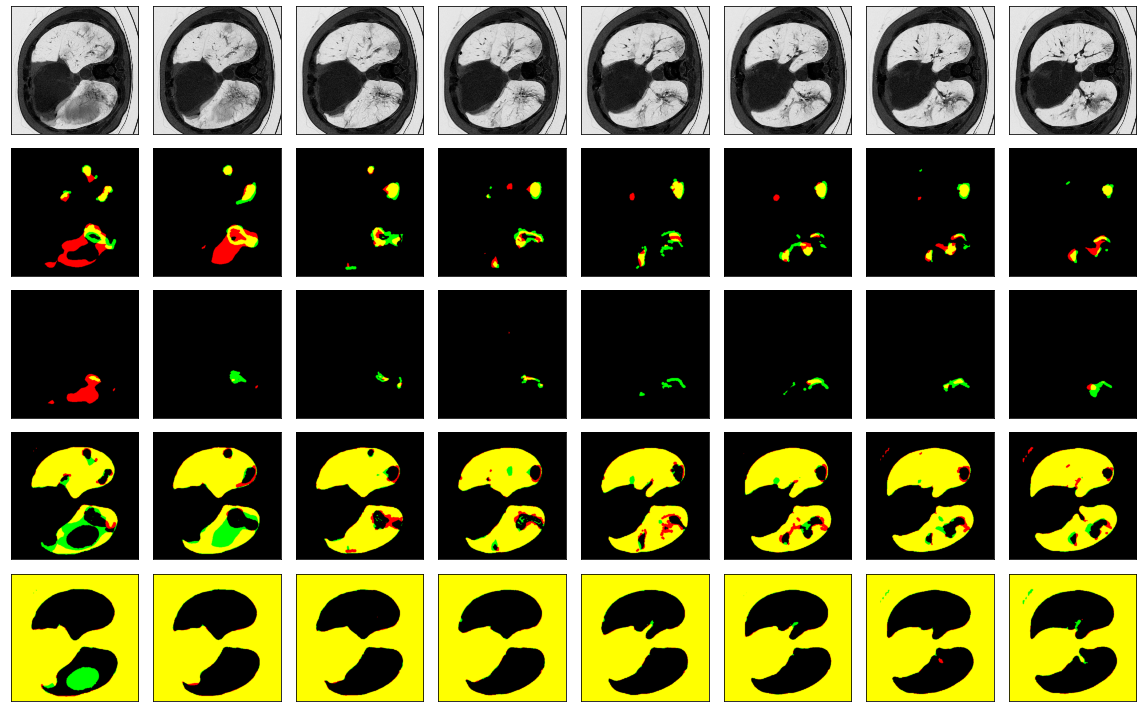

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# PSPNet + Inceptionresnet V2

Model define

In [ ]:
from segmentation_models import PSPNet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='inceptionresnetv2',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_203 (Conv2D)         (None, 384, 384, 3)       6         
                                                                 
 model (Functional)          (None, 384, 384, 4)       3572452   
                                                                 
Total params: 3,572,458
Trainable params: 3,560,682
Non-trainable params: 11,776
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Kaggle MnC/pspnet/Models/K-pspnet-inceptionresnetv2.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Kaggle MnC/pspnet/CSV/K-pspnet-inceptionresnetv2.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 93s 1s/step - loss: 0.0760 - iou_score: 0.4209 - f1-score: 0.4509 - val_loss: 0.2787 - val_iou_score: 0.5682 - val_f1-score: 0.5821 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 46s 1s/step - loss: 0.0233 - iou_score: 0.5354 - f1-score: 0.5816 - val_loss: 0.1725 - val_iou_score: 0.5858 - val_f1-score: 0.6098 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 46s 1s/step - loss: 0.0190 - iou_score: 0.6287 - f1-score: 0.7078 - val_loss: 0.0450 - val_iou_score: 0.7045 - val_f1-score: 0.7335 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 45s 1s/step - loss: 0.0162 - iou_score: 0.6822 - f1-score: 0.7680 - val_loss: 0.0380 - val_iou_score: 0.7192 - val_f1-score: 0.7483 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 45s 1s/step - loss: 0.0156 - iou_score: 0.7124 - f1-score: 0.7983 - val_loss: 0.0233 - val_iou_score: 0.7937 - val_f1-score: 0.8385 - lr: 0.0010
Epoch 6/50
40/4

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.009338
mean iou_score: 0.79839
mean f1-score: 0.87095


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0076642
mean iou_score: 0.81931
mean f1-score: 0.85277


Plots

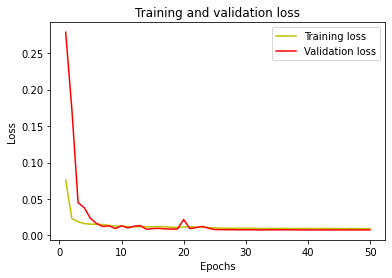

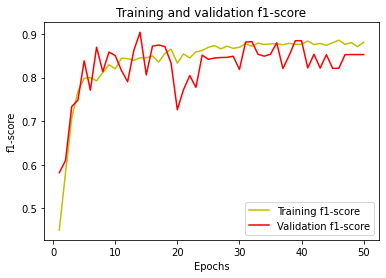

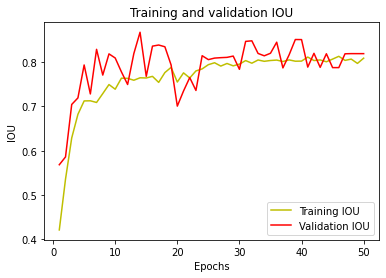

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Linknet/Models/K-Linknet-EfficientnetB3.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.020141
mean iou_score: 0.64424
mean f1-score: 0.71856


In [ ]:
print(scores_test)

[0.020140884444117546, 0.6442448496818542, 0.7185566425323486]


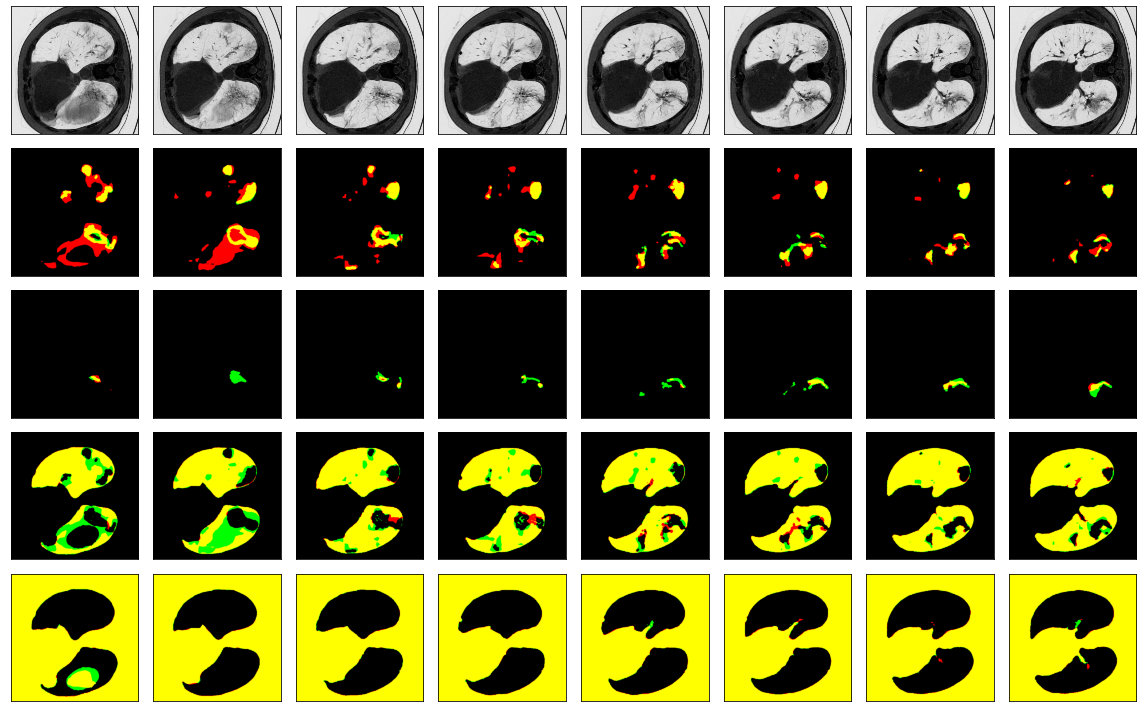

In [ ]:
input = test_dataloader[2]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# PSPNet + Densenet 121

Model define

In [ ]:
from segmentation_models import PSPNet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='densenet121',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

29097984/29084464 [==============================] - 0s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/K-pspnet-densenet121.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/K-pspnet-densenet121.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 47s 1s/step - loss: 0.0264 - iou_score: 0.4892 - f1-score: 0.5155 - val_loss: 0.0350 - val_iou_score: 0.6617 - val_f1-score: 0.6824 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 45s 1s/step - loss: 0.0216 - iou_score: 0.5527 - f1-score: 0.6051 - val_loss: 0.0333 - val_iou_score: 0.6628 - val_f1-score: 0.6835 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 45s 1s/step - loss: 0.0198 - iou_score: 0.6155 - f1-score: 0.6907 - val_loss: 0.0246 - val_iou_score: 0.6952 - val_f1-score: 0.7307 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 46s 1s/step - loss: 0.0203 - iou_score: 0.6217 - f1-score: 0.6991 - val_loss: 0.1041 - val_iou_score: 0.6040 - val_f1-score: 0.6387 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 45s 1s/step - loss: 0.0164 - iou_score: 0.6887 - f1-score: 0.7752 - val_loss: 0.0174 - val_iou_score: 0.7452 - val_f1-score: 0.7856 - lr: 0.0010
Epoch 6/50
40/4

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.009222
mean iou_score: 0.81137
mean f1-score: 0.88286


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0074789
mean iou_score: 0.7579
mean f1-score: 0.79112


Plots

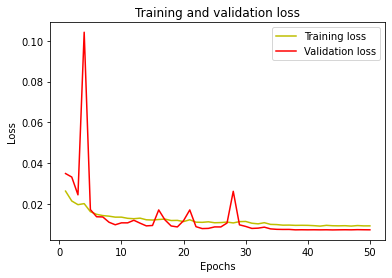

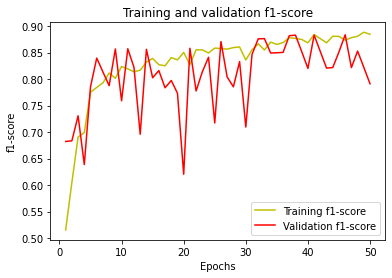

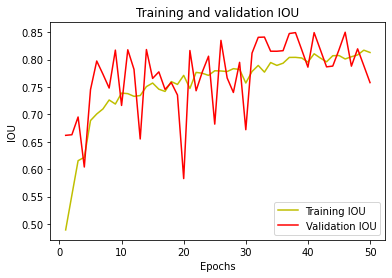

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.019195
mean iou_score: 0.6561
mean f1-score: 0.73117


In [ ]:
print(scores_test)

[0.01919516921043396, 0.6560972929000854, 0.7311721444129944]


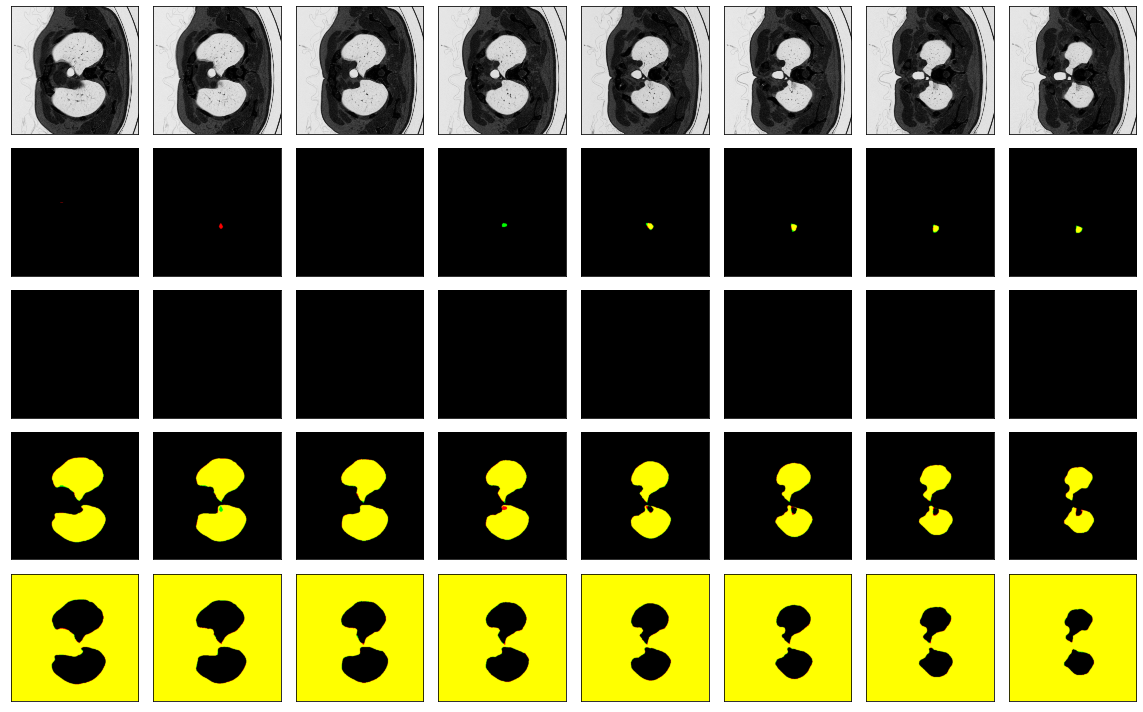

In [ ]:
input = test_dataloader[4]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# PSPNet + mobilenetv2

Model define

In [ ]:
from segmentation_models import PSPNet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='mobilenetv2',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9420800/9406464 [==============================] - 0s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/K-pspnet-mobilenetv2.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/K-pspnet-mobilenetv2.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 43s 871ms/step - loss: 0.0871 - iou_score: 0.4132 - f1-score: 0.4469 - val_loss: 0.1468 - val_iou_score: 0.5180 - val_f1-score: 0.5387 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 34s 838ms/step - loss: 0.0300 - iou_score: 0.4719 - f1-score: 0.4929 - val_loss: 0.0854 - val_iou_score: 0.5605 - val_f1-score: 0.5959 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 34s 851ms/step - loss: 0.0237 - iou_score: 0.5469 - f1-score: 0.6017 - val_loss: 0.0723 - val_iou_score: 0.5876 - val_f1-score: 0.6258 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 34s 839ms/step - loss: 0.0209 - iou_score: 0.5992 - f1-score: 0.6720 - val_loss: 0.0651 - val_iou_score: 0.5994 - val_f1-score: 0.6365 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 34s 838ms/step - loss: 0.0187 - iou_score: 0.6414 - f1-score: 0.7255 - val_loss: 0.0565 - val_iou_score: 0.6101 - val_f1-score: 0.6462 - lr: 0.0010


In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.034158
mean iou_score: 0.60998
mean f1-score: 0.69676


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.014021
mean iou_score: 0.64074
mean f1-score: 0.68439


Plots

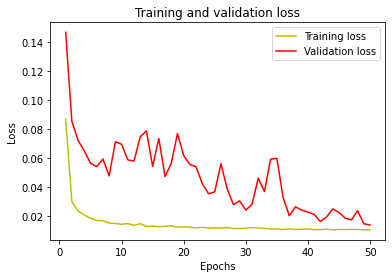

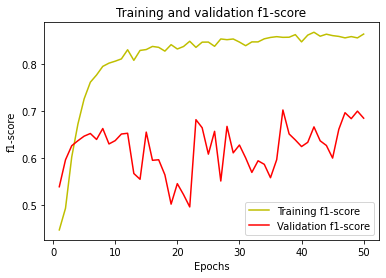

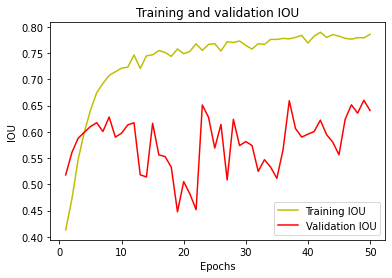

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.029578
mean iou_score: 0.52966
mean f1-score: 0.60857


In [ ]:
print(scores_test)

[0.02957775816321373, 0.5296580195426941, 0.6085730791091919]


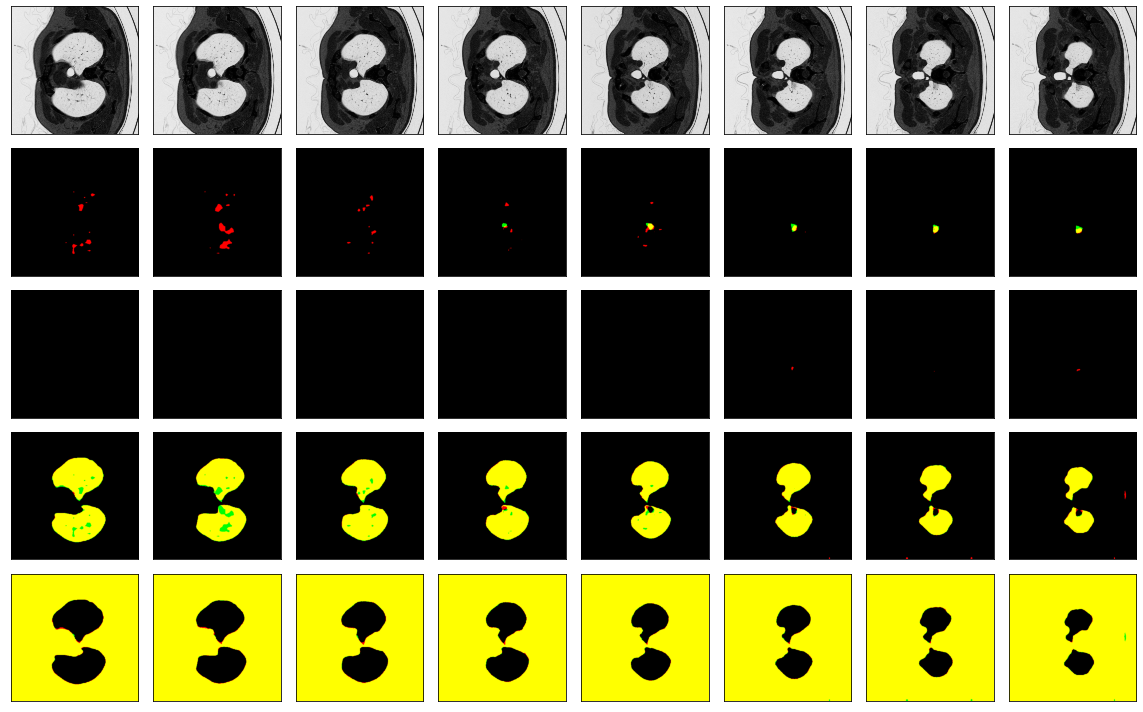

In [ ]:
input = test_dataloader[4]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# PSPNet + seresnext101

Model define

In [ ]:
from segmentation_models import PSPNet
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='seresnext101',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

193011712/192995976 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1195 (Conv2D)        (None, 384, 384, 3)       6         
                                                                 
 model_3 (Functional)        (None, 384, 384, 4)       3971956   
                                                                 
Total params: 3,971,962
Trainable params: 3,953,914
Non-trainable params: 18,048
_________________________________________________________________


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/K-pspnet-seresnext101.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/K-pspnet-seresnext101.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 96s 2s/step - loss: 0.0561 - iou_score: 0.4589 - f1-score: 0.4899 - val_loss: 0.0891 - val_iou_score: 0.6768 - val_f1-score: 0.7129 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 71s 2s/step - loss: 0.0198 - iou_score: 0.5961 - f1-score: 0.6633 - val_loss: 0.0331 - val_iou_score: 0.7031 - val_f1-score: 0.7226 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 71s 2s/step - loss: 0.0163 - iou_score: 0.6838 - f1-score: 0.7666 - val_loss: 0.0594 - val_iou_score: 0.6347 - val_f1-score: 0.6772 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 71s 2s/step - loss: 0.0148 - iou_score: 0.7094 - f1-score: 0.7943 - val_loss: 0.0300 - val_iou_score: 0.7512 - val_f1-score: 0.7935 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 71s 2s/step - loss: 0.0140 - iou_score: 0.7294 - f1-score: 0.8144 - val_loss: 0.0165 - val_iou_score: 0.7909 - val_f1-score: 0.8327 - lr: 0.0010
Epoch 6/50
40/4

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0087235
mean iou_score: 0.82471
mean f1-score: 0.89374


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0074346
mean iou_score: 0.82177
mean f1-score: 0.8545


Plots

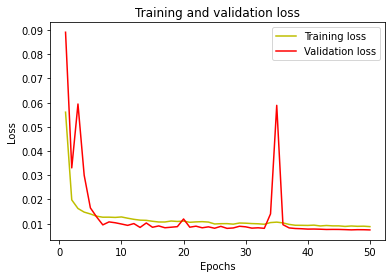

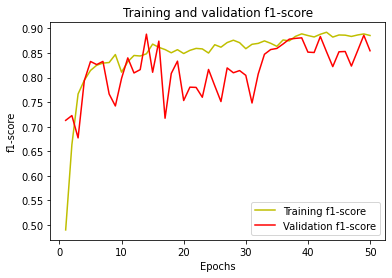

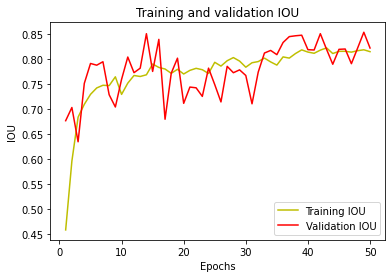

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.019079
mean iou_score: 0.66179
mean f1-score: 0.7392


In [ ]:
print(scores_test)

[0.01907927542924881, 0.6617904305458069, 0.7391999959945679]


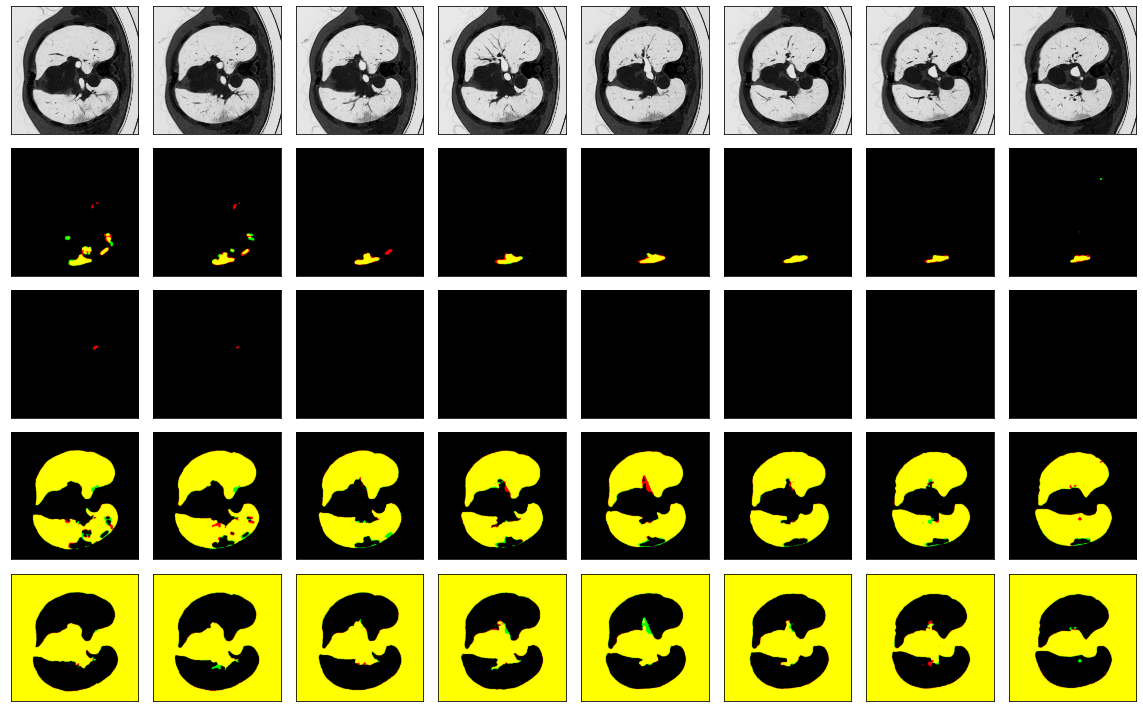

In [ ]:
input = test_dataloader[3]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN